# Travaux pratiques : Séance 3
## Deuxième partie : trouver la meilleur valeur de K avec une boucle et la cross-validation

Importation des librairies et des modules nécessaires

In [1]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np

Importation du dataset et sauvegarde de la partie data/target

In [2]:
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

# Boucle pour faire une cross-validation 
# (à l'interieur de la boucle pour trouver la valeur optimale de K)

Faisons maintenant à nouveau la même opération mais en utilisant la validation croisée : pour chaque valeur de K, nous entraînons le modèle cinq fois, en modifiant la distribution d'entraînement et de validation.

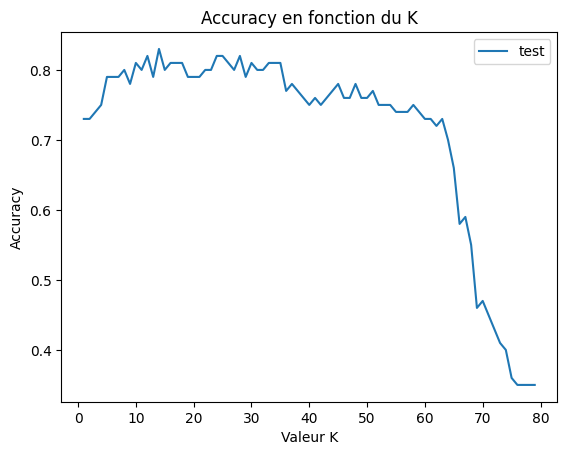

Max de l'ensemble de test :  0.83
Valeur K correspondante :  13


=== Toutes les valeurs ===
Accuracy de test :  [np.float64(0.73), np.float64(0.73), np.float64(0.74), np.float64(0.75), np.float64(0.79), np.float64(0.79), np.float64(0.79), np.float64(0.8), np.float64(0.78), np.float64(0.81), np.float64(0.8), np.float64(0.82), np.float64(0.79), np.float64(0.83), np.float64(0.8), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.79), np.float64(0.79), np.float64(0.79), np.float64(0.8), np.float64(0.8), np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.8), np.float64(0.82), np.float64(0.79), np.float64(0.81), np.float64(0.8), np.float64(0.8), np.float64(0.81), np.float64(0.8099999999999999), np.float64(0.8099999999999999), np.float64(0.77), np.float64(0.78), np.float64(0.77), np.float64(0.76), np.float64(0.75), np.float64(0.76), np.float64(0.75), np.float64(0.76), np.float64(0.77), np.float64(0.78), np.float64(0.76), np.float64(0.76), np.float64(0.78), np

In [4]:
max_k = 80

list_accuracy = []

for i in range (1, max_k):
    # Déclarons l'instance du modèle
    clf = KNeighborsClassifier(n_neighbors=i)
    
    # La fonction du cross-validation
    accuracy_scores = cross_val_score(clf, X_train, y_train, cv=5) # C'est 5-fold cross-validation

    # Enregistrons le résultat moyen des cinq séances d'entraînement dans une liste
    list_accuracy.append(mean(accuracy_scores))


# visualisons les résultats
plt.plot(range (1, max_k),list_accuracy, label = 'test')
plt.xlabel("Valeur K")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du K")
plt.legend()
plt.show()

print("Max de l'ensemble de test : ", max(list_accuracy)) 
best_K = list_accuracy.index(max(list_accuracy))
print("Valeur K correspondante : ", best_K)
print()
print()
print("=== Toutes les valeurs ===")
print("Accuracy de test : ", list_accuracy)



<b> Maintenant, entrainons à nouveau le modèle sur un partie des donnèes avec le meilleur K e vérifions l'accuracy sur l'autre partie

In [5]:
clf = KNeighborsClassifier(n_neighbors=best_K)
clf.fit(X_train,y_train)

y_pred_test = clf.predict(X_test)
accuracy_test = accuracy_score(y_pred_test, y_test)
print("Accuracy finale de l'ensemble de test : ", accuracy_test)

y_pred_train = clf.predict(X_train)
accuracy_train = accuracy_score(y_pred_train, y_train)
print("Accuracy finale de l'ensemble d'entrainement : ", accuracy_train)


Accuracy finale de l'ensemble de test :  0.76
Accuracy finale de l'ensemble d'entrainement :  0.81


# Nous avons utilisé cross_val_score. Si nous voulons séparer l'ensemble de données manuellement, on peut écrire une fonction pour prendre sa place:

In [6]:
def notre_cross_validation (clf, X, y, num_folds):
    list_accuracy_train = []
    list_accuracy_val = []

    # mélangeons d’abord l’ensemble de données
    y = y.reshape(-1, 1)
    Xy = np.hstack((X, y))
    np.random.shuffle(Xy)
    X_trainvalidate = Xy[:,:-1]
    y_trainvalidate = Xy[:,-1].flatten()
    
    # la taille d'une portion
    a = int(len(X_trainvalidate)/5)
    
    for i in range (num_folds):

        # ---> la partie destinée à la validation
        X_val = X_trainvalidate[a*i:a*(i+1)]
        y_val = y_trainvalidate[a*i:a*(i+1)]

        # ---> la partie destinée à la validation
        # puisque nous sélectionnons des lignes de l'ensemble de données pour la validation, 
        # nous devons prendre tout ce qui reste pour la formation, c'est-à-dire toutes les lignes 
        # qui précèdent et celles qui suivent et les rassembler dans un tableau
        X_train_ante_validation = X_trainvalidate[:a*i]
        X_train_post_validation = X_trainvalidate[a*(i+1):]
        X_train = np.concatenate([X_train_ante_validation, X_train_post_validation])

        # après avoir fait l'opération pour les features, on le fait aussi sur la target
        y_train_ante_validation = y_trainvalidate[:a*i]
        y_train_post_validation = y_trainvalidate[a*(i+1):]
        y_train = np.concatenate([y_train_ante_validation, y_train_post_validation])

        # maintenant nous sommes prêts à faire la training
        clf.fit(X_train, y_train)

        # puisque nous créons la fonction, nous pouvons faire mieux que cross_val_score 
        # et également renvoyer l'accuracy sur les données d'entraînement

        # calculons la accuracy sur les données de validation
        y_pred_test = clf.predict(X_val)
        accuracy_val = accuracy_score(y_pred_test, y_val)
        list_accuracy_val.append(accuracy_val)

        # calculons la accuracy sur les données d'entraînement
        y_pred_train = clf.predict(X_train)
        accuracy_train = accuracy_score(y_pred_train, y_train)
        list_accuracy_train.append(accuracy_train)

    return list_accuracy_val, list_accuracy_train

    

<b> Et maintenant on fait la même opération que le bloc précédent, mais en utilisant notre fonction

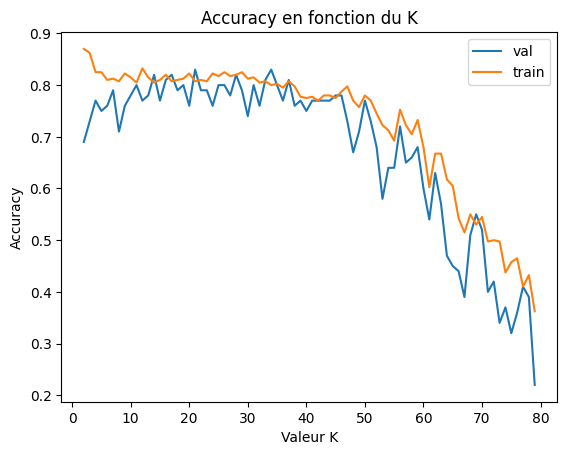

Max de l'ensemble de val :  0.8300000000000001
Valeur K correspondante :  19


=== Toutes les valeurs ===
Accuracy de val :  [np.float64(0.73), np.float64(0.73), np.float64(0.74), np.float64(0.75), np.float64(0.79), np.float64(0.79), np.float64(0.79), np.float64(0.8), np.float64(0.78), np.float64(0.81), np.float64(0.8), np.float64(0.82), np.float64(0.79), np.float64(0.83), np.float64(0.8), np.float64(0.81), np.float64(0.81), np.float64(0.81), np.float64(0.79), np.float64(0.79), np.float64(0.79), np.float64(0.8), np.float64(0.8), np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.8), np.float64(0.82), np.float64(0.79), np.float64(0.81), np.float64(0.8), np.float64(0.8), np.float64(0.81), np.float64(0.8099999999999999), np.float64(0.8099999999999999), np.float64(0.77), np.float64(0.78), np.float64(0.77), np.float64(0.76), np.float64(0.75), np.float64(0.76), np.float64(0.75), np.float64(0.76), np.float64(0.77), np.float64(0.78), np.float64(0.76), np.float64(0.76), np.float

In [7]:
list_accuracy_val = []
list_accuracy_train = []

for i in range (2, max_k):
    clf = KNeighborsClassifier(n_neighbors=i)
    accuracy_scores_val, accuracy_scores_train = notre_cross_validation(clf, X_train, y_train, 5) # C'est 5-fold cross-validation
    list_accuracy_val.append(mean(accuracy_scores_val))
    list_accuracy_train.append(mean(accuracy_scores_train))


plt.plot(range (2, max_k),list_accuracy_val, label = 'val')
plt.plot(range (2, max_k),list_accuracy_train, label = 'train')

plt.xlabel("Valeur K")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du K")
plt.legend()
plt.show()


print("Max de l'ensemble de val : ", max(list_accuracy_val)) 
best_K = list_accuracy_val.index(max(list_accuracy_val))
print("Valeur K correspondante : ", best_K)
print()
print()
print("=== Toutes les valeurs ===")
print("Accuracy de val : ", list_accuracy)



<b> Entraînement final du modèle.

In [8]:
clf = KNeighborsClassifier(n_neighbors=best_K)
clf.fit(X_train,y_train)

y_pred_test = clf.predict(X_test)
accuracy_test = accuracy_score(y_pred_test, y_test)
print("Accuracy finale de l'ensemble de test : ", accuracy_test)

y_pred_train = clf.predict(X_train)
accuracy_train = accuracy_score(y_pred_train, y_train)
print("Accuracy finale de l'ensemble d'entrainement : ", accuracy_train)


Accuracy finale de l'ensemble de test :  0.8
Accuracy finale de l'ensemble d'entrainement :  0.81


<b>Affichage des frontières de décision

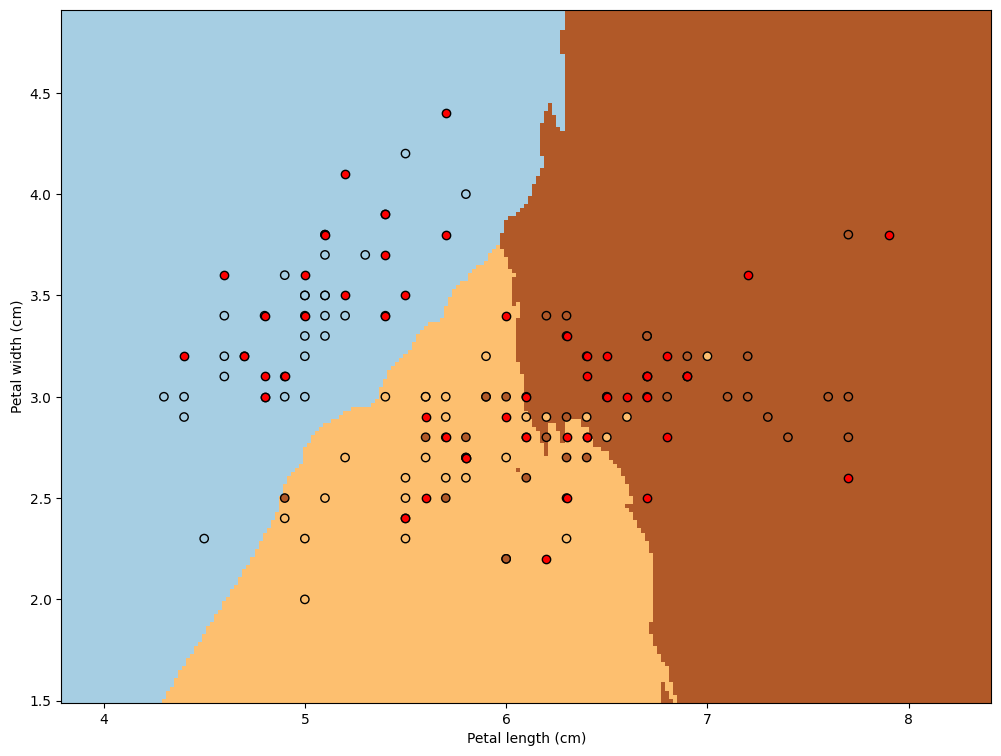

In [9]:
h = .02

x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(12, 9))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, edgecolors='k')
plt.scatter(X_test[:,0], X_test[:,1],c='r', edgecolors='k')
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')

plt.show()